# [영화 리뷰를 사용한 텍스트 분류](https://www.tensorflow.org/tutorials/keras/text_classification?hl=ko)

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

2.4.1


In [4]:
# IMDB 데이터셋 다운로드
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)
(train_data.shape, train_labels.shape), (test_data.shape, test_labels.shape)

(((25000,), (25000,)), ((25000,), (25000,)))

In [5]:
# EDA
print("훈련 샘플: {}, 레이블: {}".format(len(train_data), len(train_labels)))

훈련 샘플: 25000, 레이블: 25000


In [6]:
# Sample
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [7]:
# 영화 리뷰들은 길이가 다르다.
len(train_data[0]), len(train_data[1])

(218, 189)

In [11]:
# 정수를 단어로 다시 변환
# 단어와 정수 인덱스를 매핑한 딕셔너리
word_index = imdb.get_word_index()

# TODO 이 기법이 자주 쓰이는 듯하다.
# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [12]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

## 데이터 준비
리뷰-정수 배열을 신경망에 주입하기 전에 Tensor로 변환이 필요하다. 2가지 방법이 있다.
1. one-hot (Large Memory)
2. padding 추가 (이런 형태의 Tensor를 Embedding츠엥서 다룰 수 있음)

여기서는 2번 방법을 사용한다. 

In [18]:
# keras.preprocessing.sequence !
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

In [19]:
# 전처리된 샘플의 길이
len(train_data[0]), len(train_data[1])

(256, 256)

In [20]:
# 패딩된 첫번째 리뷰내용 확인
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

## 모델 구성
2가지를 결정해야 한다.
* 모델에서 얼마나 많은 층을 사용할 것인가?
* 각 층에서 얼마나 많은 은닉 유닛을 사용할 것인가?

In [23]:
# 메모리를 줄이는 기법에 가까운듯...
# 입력 크기는 영화 리뷰 데이터셋에 적용된 어휘 사전의 크기입니다(10,000개의 단어)
vocab_size = 10000

model = keras.Sequential()
# input_shape을 256을 입력하면, (batch, sequence, embedding) 에서 sequence가 256으로 바뀜
model.add(keras.layers.Embedding(vocab_size, 16, input_shape=(None,))) 
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d_3 ( (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


층을 순서대로 쌓아 분류기(classifier)를 만듭니다:

1. 첫 번째 층은 Embedding 층입니다. 이 층은 정수로 인코딩된 단어를 입력 받고 각 단어 인덱스에 해당하는 임베딩 벡터를 찾습니다. 이 벡터는 모델이 훈련되면서 학습됩니다. 이 벡터는 출력 배열에 새로운 차원으로 추가됩니다. 최종 차원은 (batch, sequence, embedding)이 됩니다.
2. 그다음 GlobalAveragePooling1D 층은 sequence 차원에 대해 평균을 계산하여 각 샘플에 대해 고정된 길이의 출력 벡터를 반환합니다. 이는 길이가 다른 입력을 다루는 가장 간단한 방법입니다.
3. 이 고정 길이의 출력 벡터는 16개의 은닉 유닛을 가진 완전 연결(fully-connected) 층(Dense)을 거칩니다.
4. 마지막 층은 하나의 출력 노드(node)를 가진 완전 연결 층입니다. sigmoid 활성화 함수를 사용하여 0과 1 사이의 실수를 출력합니다. 이 값은 확률 또는 신뢰도를 나타냅니다.

In [24]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [25]:
# Validation Set 생성
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [26]:
# Model train
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 2s 24ms/step - loss: 0.6925 - accuracy: 0.5131 - val_loss: 0.6897 - val_accuracy: 0.6878
Epoch 2/40
30/30 [==============================] - 0s 10ms/step - loss: 0.6875 - accuracy: 0.6821 - val_loss: 0.6817 - val_accuracy: 0.7198
Epoch 3/40
30/30 [==============================] - 0s 10ms/step - loss: 0.6768 - accuracy: 0.7340 - val_loss: 0.6665 - val_accuracy: 0.7379
Epoch 4/40
30/30 [==============================] - 0s 10ms/step - loss: 0.6577 - accuracy: 0.7582 - val_loss: 0.6424 - val_accuracy: 0.7469
Epoch 5/40
30/30 [==============================] - 0s 10ms/step - loss: 0.6277 - accuracy: 0.7783 - val_loss: 0.6095 - val_accuracy: 0.7810
Epoch 6/40
30/30 [==============================] - 0s 10ms/step - loss: 0.5890 - accuracy: 0.8031 - val_loss: 0.5715 - val_accuracy: 0.7945
Epoch 7/40
30/30 [==============================] - 0s 10ms/step - loss: 0.5495 - accuracy: 0.8116 - val_loss: 0.5296 - val_accuracy: 0.8185
Epoch 8/40
30

In [29]:
# Model Eval.
# 이 예제는 매우 단순한 방식을 사용하므로 87% 정도의 정확도를 달성했습니다. 
# 고급 방법을 사용한 모델은 95%에 가까운 정확도를 얻습니다.
results = model.evaluate(test_data,  test_labels, verbose=2)

print(results)

782/782 - 1s - loss: 0.3313 - accuracy: 0.8716
[0.3313167989253998, 0.8715999722480774]


In [31]:
# model.fit()은 History 객체를 반환합니다. 
# 여기에는 훈련하는 동안 일어난 모든 정보가 담긴 딕셔너리(dictionary)가 들어 있습니다:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

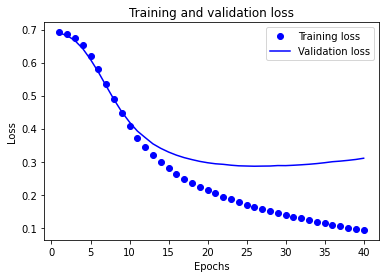

In [32]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

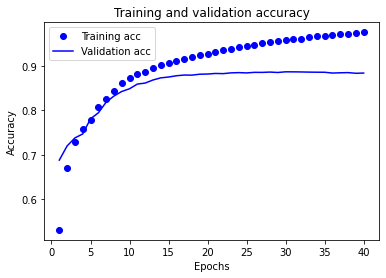

In [33]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

이 그래프에서 점선은 훈련 손실과 훈련 정확도를 나타냅니다. 실선은 검증 손실과 검증 정확도입니다.

훈련 손실은 에포크마다 감소하고 훈련 정확도는 증가한다는 것을 주목하세요. 경사 하강법 최적화를 사용할 때 볼 수 있는 현상입니다. 매 반복마다 최적화 대상의 값을 최소화합니다.

하지만 검증 손실과 검증 정확도에서는 그렇지 못합니다. 약 20번째 에포크 이후가 최적점인 것 같습니다. 이는 과대적합 때문입니다. 이전에 본 적 없는 데이터보다 훈련 데이터에서 더 잘 동작합니다. 이 지점부터는 모델이 과도하게 최적화되어 테스트 데이터에서 일반화되기 어려운 훈련 데이터의 특정 표현을 학습합니다.

여기에서는 과대적합을 막기 위해 단순히 20번째 에포크 근처에서 훈련을 멈출 수 있습니다. 나중에 콜백(callback)을 사용하여 자동으로 이렇게 하는 방법을 배워 보겠습니다.


